In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
from prophet import Prophet

In [96]:
# The task is to forecast the total amount of products sold in every shop for the test set. 
# Note that the list of shops and products slightly changes every month. 
# Creating a robust model that can handle such situations is part of the challenge.

In [97]:
df = pd.read_csv('sales_train.csv')
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [98]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [100]:
df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [101]:
duplicates_subset = df.duplicated(subset=['date','shop_id','item_id']).sum()
print(duplicates_subset)
print(len(df))

# drop duplicates 
df = df.drop_duplicates(subset= ['date','shop_id','item_id'])
print(len(df))
df

28
2935849
2935821


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [102]:
df = df.sort_values(by='date')
df = df.groupby(['date']).agg(
    price = ('item_price','sum'),
    item_count = ('item_cnt_day','sum')
)
df

,price,item_count
date,,
01.01.2013,1.211779e+06,1951.0
01.01.2014,1.702078e+06,2310.0
01.01.2015,2.329375e+06,2117.0
01.02.2013,2.246770e+06,3817.0
01.02.2014,3.513899e+06,5711.0
...,...,...
31.10.2013,2.439256e+06,3826.0
31.10.2014,2.824445e+06,3014.0
31.10.2015,2.847151e+06,3104.0


In [103]:
df = df.reset_index().sort_values(by='date')
df['date'] = pd.to_datetime(df['date'],format="%d.%m.%Y")
df.head()

,date,price,item_count
0,2013-01-01,1.211779e+06,1951.0
1,2014-01-01,1.702078e+06,2310.0
2,2015-01-01,2.329375e+06,2117.0
3,2013-02-01,2.246770e+06,3817.0
4,2014-02-01,3.513899e+06,5711.0


In [104]:
df.date.max()
# df.date.min()

Timestamp('2015-10-31 00:00:00')

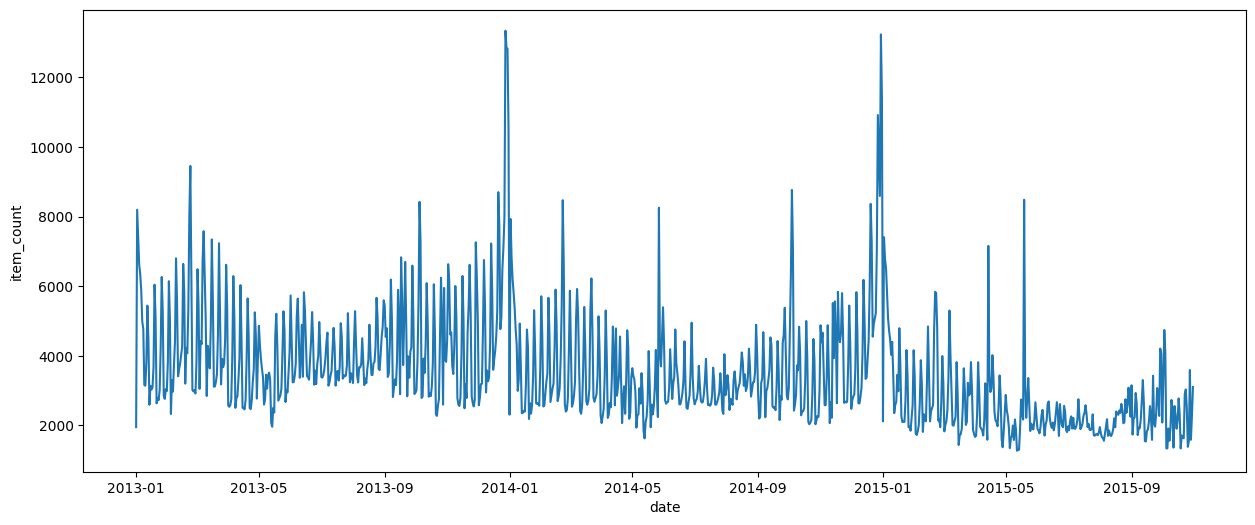

In [105]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df.date, y=df.item_count)
plt.show()

In [106]:
split_date = '2015-01-01'

sales_data_train = df[df.date<=split_date]
sales_data_test = df[df.date>=split_date]

train_data = sales_data_train.reset_index().rename(columns={'date':'ds','item_count':'y'})
test_data = sales_data_test.reset_index().rename(columns={'date':'ds','item_count':'y'})
train_data = train_data[['ds','y']]
test_data = test_data[['ds','y']]
print('Train data:', train_data['ds'][0],'to',train_data['ds'].max(),'\nTotal length:',len(train_data))
print('Test data:',test_data['ds'][0],'to',test_data['ds'].max(),'\nTotal length:',len(test_data))

Train data: 2013-01-01 00:00:00 to 2015-01-01 00:00:00 
Total length: 731
Test data: 2015-01-01 00:00:00 to 2015-10-31 00:00:00 
Total length: 304


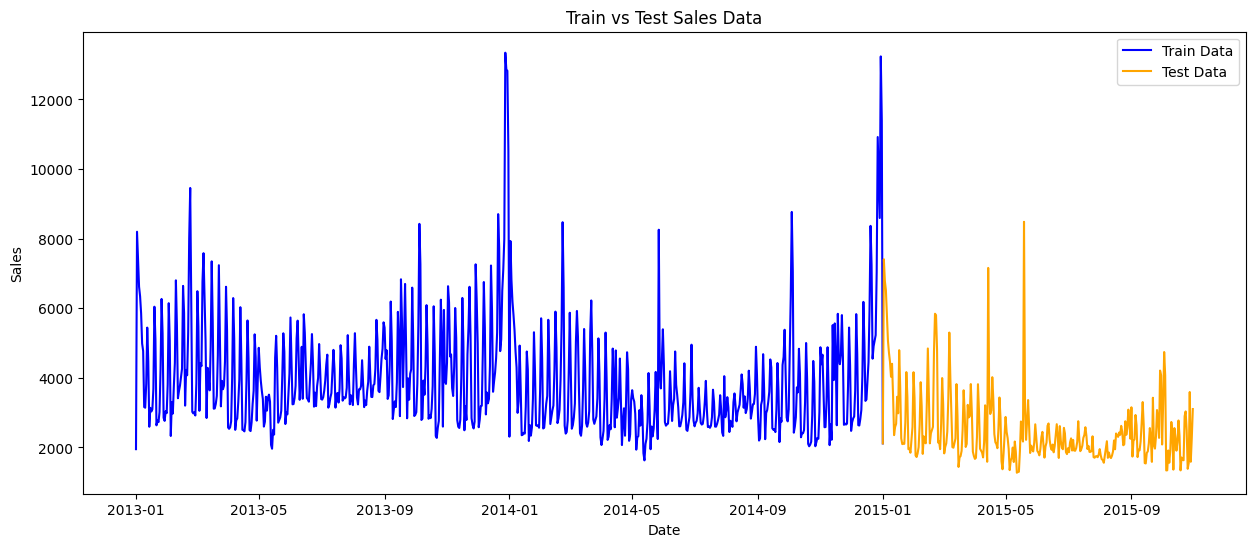

In [107]:
plt.figure(figsize=(15, 6))

# Plot training data
sns.lineplot(x=sales_data_train.date, y=sales_data_train['item_count'], label='Train Data', color='blue')

# Plot testing data
sns.lineplot(x=sales_data_test.date, y=sales_data_test['item_count'], label='Test Data', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Train vs Test Sales Data')
plt.legend()

# Show the plot
plt.show()

# Propeht Model 

In [108]:
%time
model = Prophet()
model.fit(train_data)

15:12:54 - cmdstanpy - INFO - Chain [1] start processing


CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 1.91 μs


15:12:54 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# check components 
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [115]:
# Predict for test data (2015-01-01 to 2015-10-31)

forecasted_test_data = model.predict(test_data)

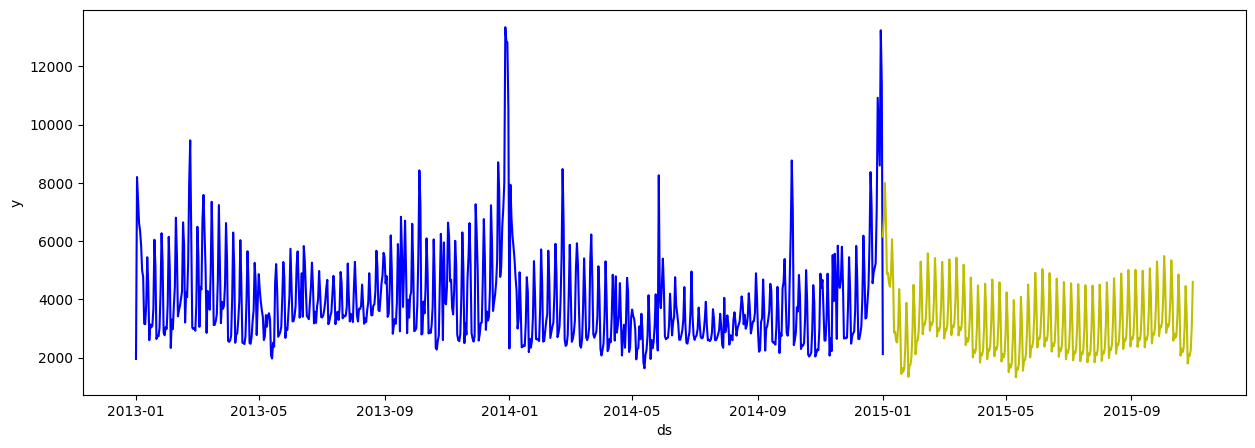

In [121]:
# Plot for train and predicted test data 

plt.figure(figsize=(15,5))
sns.lineplot(x=train_data['ds'], y=train_data['y'],color='b')
sns.lineplot(x=forecasted_test_data['ds'], y=forecasted_test_data['yhat'],color='y')
plt.show()

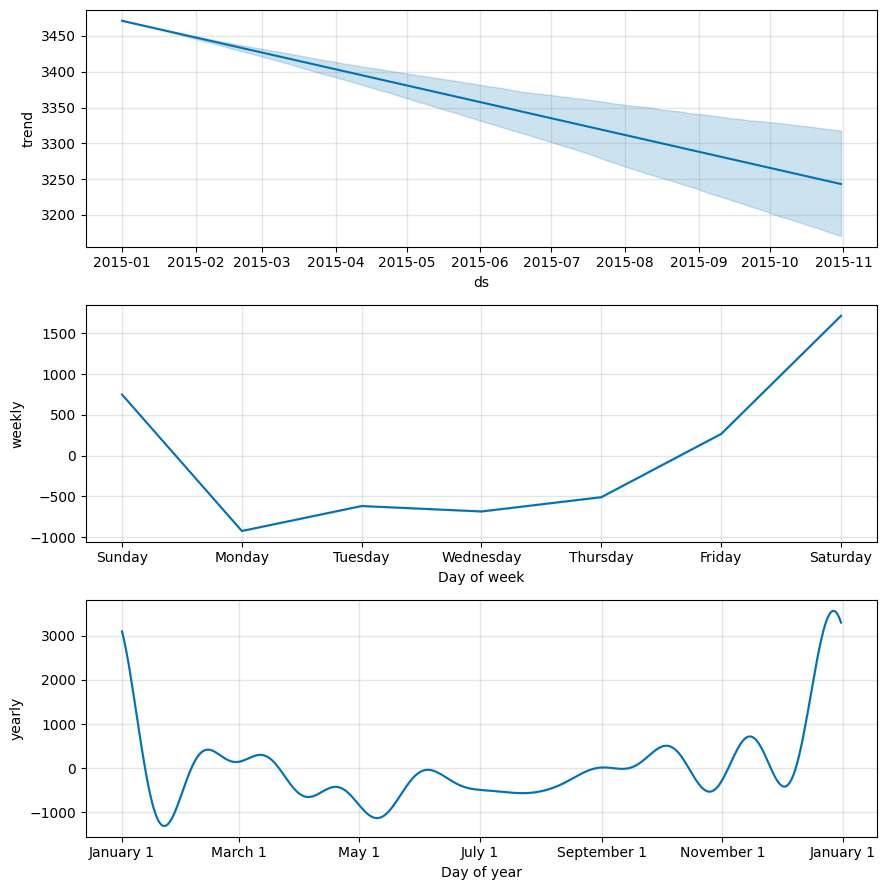

In [112]:
fig = model.plot_components(forecasted_test_data)
plt.show()

# Make future predictions for the required period 

In [123]:
future = model.make_future_dataframe(periods=365+60, include_history=False, freq='d')
future_pred = model.predict(future)
future_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,3470.527400,5594.638434,8007.483509,3470.527400,3470.527400,3278.373418,3278.373418,3278.373418,267.030938,267.030938,267.030938,3011.342480,3011.342480,3011.342480,0.0,0.0,0.0,6748.900818
1,2015-01-03,3469.773992,6757.282504,9175.246629,3469.773992,3469.773992,4519.680653,4519.680653,4519.680653,1714.488690,1714.488690,1714.488690,2805.191964,2805.191964,2805.191964,0.0,0.0,0.0,7989.454646
2,2015-01-04,3469.020585,5520.301780,7978.347481,3469.020585,3469.020585,3323.339236,3323.339236,3323.339236,749.710912,749.710912,749.710912,2573.628324,2573.628324,2573.628324,0.0,0.0,0.0,6792.359821
3,2015-01-05,3468.267178,3610.336966,6004.231929,3468.267178,3468.267178,1397.760489,1397.760489,1397.760489,-922.653794,-922.653794,-922.653794,2320.414283,2320.414283,2320.414283,0.0,0.0,0.0,4866.027667
4,2015-01-06,3467.513770,3660.578550,6095.488638,3467.513770,3467.513770,1432.835711,1432.835711,1432.835711,-616.830670,-616.830670,-616.830670,2049.666381,2049.666381,2049.666381,0.0,0.0,0.0,4900.349481


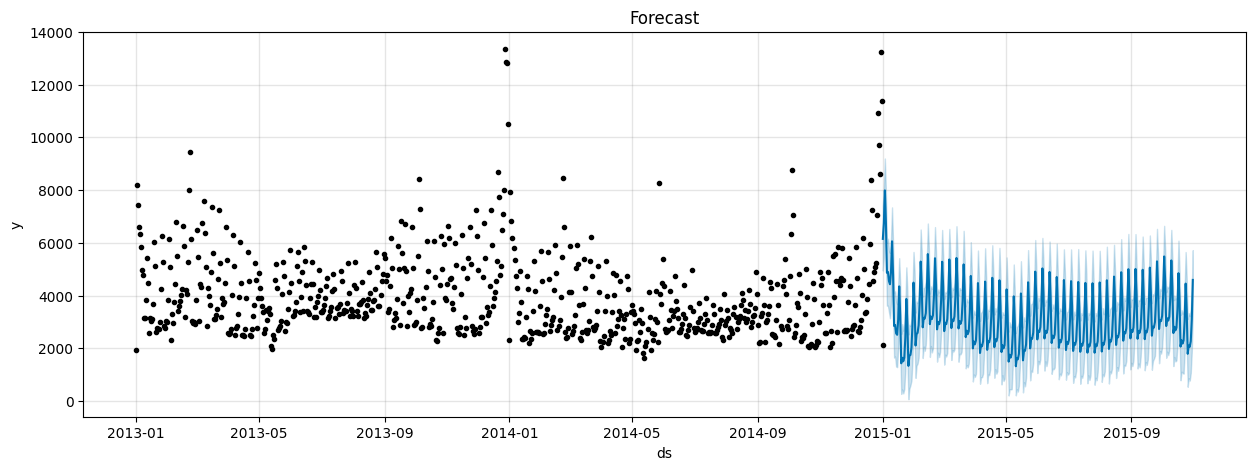

In [136]:
fig, ax = plt.subplots(figsize=(15,5))
fig = model.plot(forecasted_test_data, ax=ax)
ax.set_title('Forecast')
plt.show()


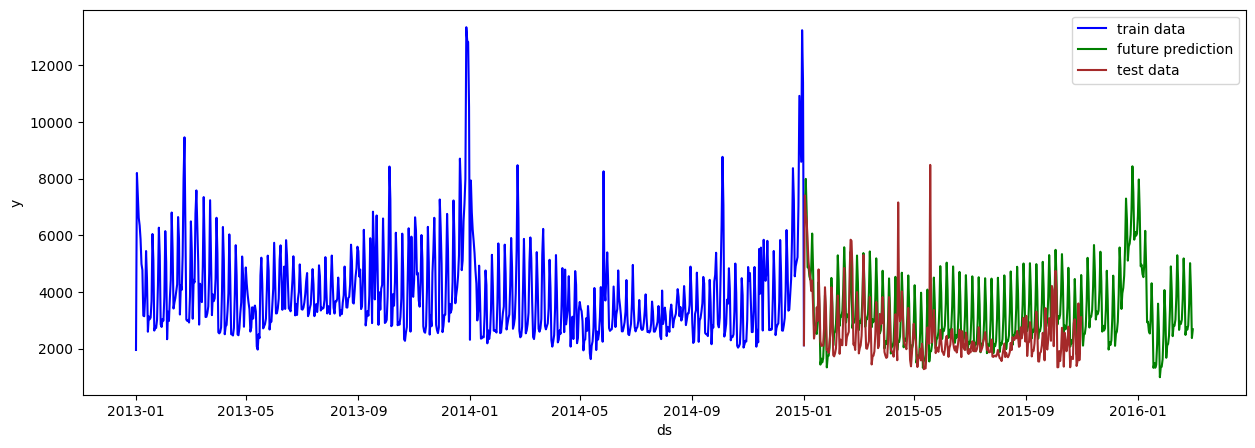

In [152]:
plt.figure(figsize=(15,5))
sns.lineplot(x=train_data['ds'], y=train_data['y'],color='b',label='train data')
sns.lineplot(x=future_pred['ds'], y=future_pred['yhat'],color='green',label='future prediction')
sns.lineplot(x=test_data['ds'],y=test_data['y'],color='brown',label='test data')

plt.legend()
plt.show()

In [146]:
future_pred[['ds','yhat']].rename(columns={'ds':'date','yhat':'item_count'}).to_csv('future_forecast_2015_to_2016.csv',index=False)